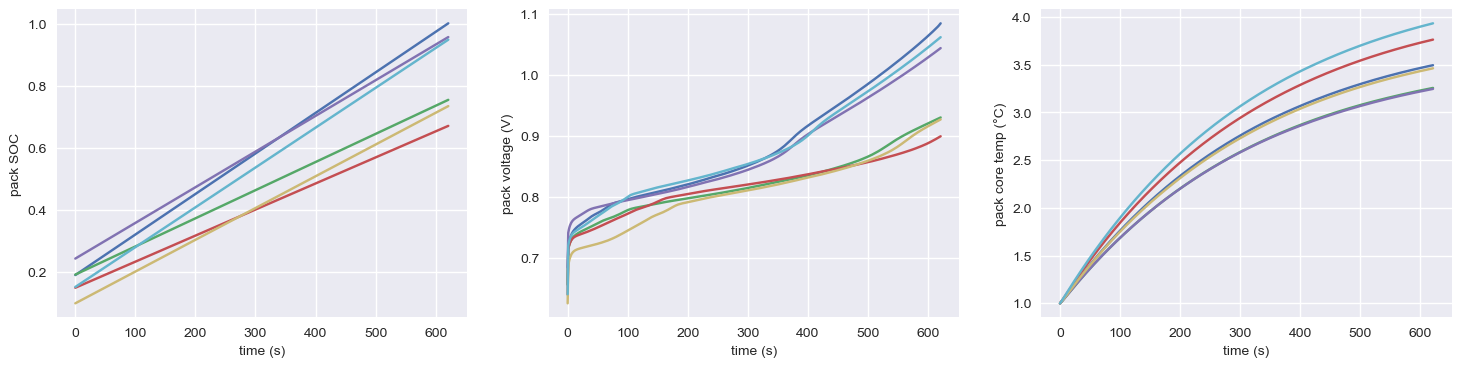

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LIBEnv.LIB_gym_delta import LIBPackEnv
plt.style.use('seaborn-v0_8') # seaborn-v0_8

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)

pack_res=[]
rewards = []
pack_res.append(env.reset()[0].reshape(3,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(7))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('time (s)')
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:])
plt.xlabel('time (s)')
plt.ylabel('pack voltage (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:])
plt.xlabel('time (s)')
plt.ylabel('pack core temp (°C)')
plt.grid('on')

# CC/CV

In [2]:
env.overcharge_voltage

4.25

In [13]:
env.step(np.zeros(7))[0][6:12]

array([1.0069742 , 0.8605933 , 0.81133807, 0.9742815 , 0.8505868 ,
       0.9690955 ], dtype=float32)

In [15]:
env.step(np.zeros(7))[0][6:12] * (env.max_voltage-env.min_voltage) + env.min_voltage

array([4.1083784, 3.8581753, 3.7737257, 4.0526776, 3.8407822, 4.0438285],
      dtype=float32)

In [21]:
v = env.step(np.zeros(7))[0][6:12] * (env.max_voltage-env.min_voltage) + env.min_voltage # fixed voltage
ik = (v - env.overcharge_voltage)/env.pack.ECM.R0Param; # compute test ik to achieve maxV

np.maximum(-100,ik)

array([[-100., -100., -100., -100., -100., -100.]])

In [26]:
np.hstack([ik.ravel()/env.current_ratio,1])

array([1.31899996, 3.90492476, 3.68226194, 2.00081225, 3.83614334,
       1.48612145, 1.        ])

In [45]:
i_balance

array([  0.     , 342.95325, 364.67538, 344.9082 , 366.07272, 353.4201 ],
      dtype=float32)

[[-1226.79586864  -568.32273945  -692.13794452  -499.7169521
  -1540.82220652  -568.57294975]]
[[-100. -100. -100. -100. -100. -100.]]
[75.63727 89.96764 86.43793 90.82197  0.      90.65562]
[[ -24.36273193  -10.03235626  -13.56207275   -9.17803192 -100.
    -9.34438324]]
[[ -24.36273193  -10.03235626  -13.56207275   -9.17803192 -100.
    -9.34438324]]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

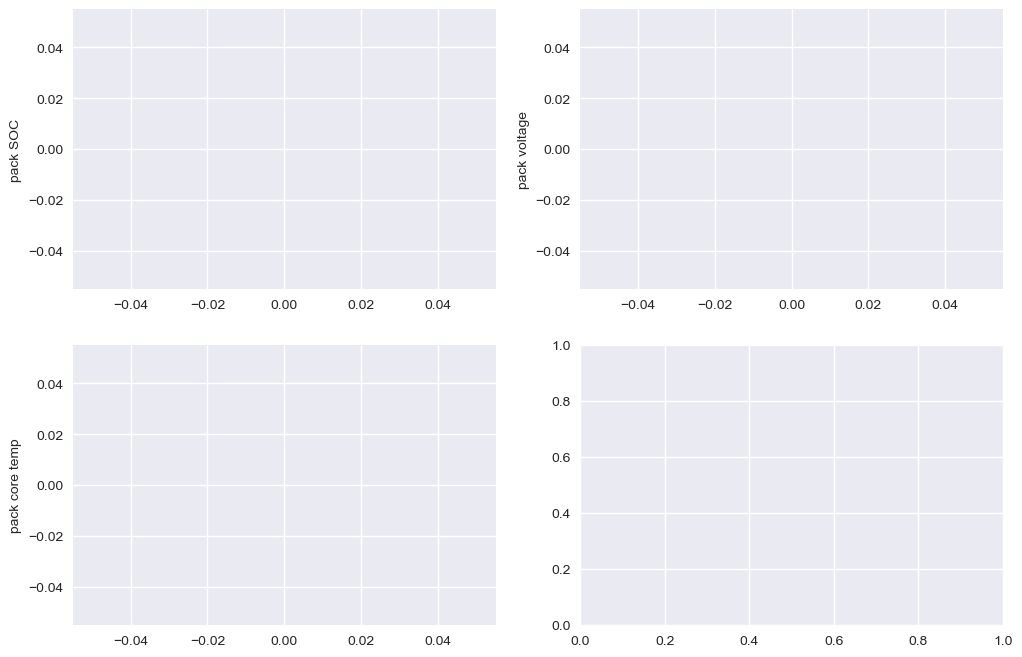

In [99]:
from copy import copy

CC = 100
Rbal = 0.04

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)
state, _ = env.reset()

pack_res = []
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    copy_env = copy(env)
    v = copy_env.step(np.zeros(7))[0][6:12] * (env.max_voltage-env.min_voltage) + env.min_voltage # fixed voltage
    ik = (v - env.overcharge_voltage)/env.pack.ECM.R0Param; # compute test ik to achieve maxV
    print(ik)
    ik = np.clip(-CC,ik,0); # but limit ik to no more than CC in mag.
    print(ik)
    # passive balancing
    cell_voltages = state[6:12]*(env.max_voltage-env.min_voltage) + env.min_voltage
    checkBalance = ((cell_voltages - cell_voltages.min()) - 1e-3 >= 0)
    v_balance = cell_voltages*checkBalance 
    # Set non-balance cell voltage to 0 for calculation (to ensure balance current = 0 for no-balance cells)
    i_balance = (v_balance/Rbal)   # Current calculated for balance cell, with parallel resistor 
    print(i_balance)
    ik = ik + i_balance             # Add balance current to externally applied cell current
    print(ik)
    ik = np.clip(-CC,ik,0)
    print(ik)
    break
    action = np.hstack([ik.ravel()/env.current_ratio,1])
    next_state, reward, done, _, info = env.step(action)
    state = next_state
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:,:-1].reshape(-1,6))
plt.ylabel('current')
plt.grid('on')

#############################################
'''

z = np.array(data['packData']['storez'])
irc = np.array(data['packData']['storeirc'])

batteryPack.z_k = z.reshape(1,-1)
batteryPack.iR_k = irc.reshape(1,-1)

cell_voltages = np.array(batteryPack.outputEqn(0))
cell_SOCs = np.array(batteryPack.z_k)

maxtime = 12*3600  # Maximum simulation run time in simulated seconds
pk = np.zeros((maxtime,1)) 
maxpk = np.zeros((maxtime,1)) 
saveV = np.zeros((maxtime,len(data['packData']['storez']))) 
saveZ = np.zeros((maxtime,len(data['packData']['storez']))) 

T = np.array(data['packData']['T'])        # Temperature for each cell, assumed to be constant
Tsd = np.array(data['packData']['Tsd']).reshape(1,100)    # Self-discharge "temperature" for each cell
leak = np.array(data['packData']['leak']).reshape(1,100)  # Leakage current for each cell
q = np.array(data['packData']['q'])        # Total capacity for each cell (all may be different)
rc = np.array(data['packData']['rc'])      # R-C time constant for each cell
r = np.array(data['packData']['r'])        # Diffusion-resistor values for each cell
r0 = np.array(data['packData']['r0'])      # Series resistance values for each cell
Rbal = 20

for k in tqdm(range(maxtime)):
    ik = np.zeros_like(cell_voltages)  # no string current
    # Simulate self discharge via variable resistor in parallel
    rsd = ((-20+0.4*Tsd)*cell_SOCs + (35-0.5*Tsd))*1e3
    ik = ik + cell_voltages/rsd 
    # Simulate leakage current
    ik = ik + leak

    checkBalance = ((cell_voltages - cell_voltages.min()) - 1e-3 >= 0)
    v_balance = cell_voltages*checkBalance 
    # Set non-balance cell voltage to 0 for calculation (to ensure balance current = 0 for no-balance cells)
    i_balance = (v_balance/Rbal)   # Current calculated for balance cell, with parallel resistor 
    ik = ik + i_balance             # Add balance current to externally applied cell current

    newState = batteryPack.stateEqn(ik)
    voltage = batteryPack.outputEqn(ik)
    batteryPack.updateState(newState)

    cell_voltages = voltage
    cell_SOCs = batteryPack.z_k.ravel()
    saveV[k,:] = voltage
    saveZ[k,:] = batteryPack.z_k.ravel()

    if k%5000 == 0:
        print(checkBalance.sum())
'''

(0.0, 50.0)

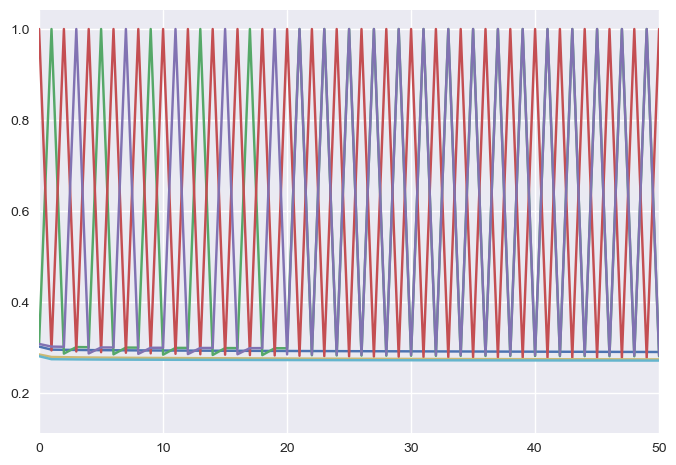

In [83]:
plt.plot(np.array(actions)[:,:-1].reshape(-1,6))
plt.xlim([0,50])

In [84]:
np.array(actions)[:,:-1].reshape(-1,6)

array([[0.30164688, 0.30863045, 1.        , 0.3074398 , 0.2842643 ,
        0.2803994 ],
       [0.29484787, 1.        , 0.29313232, 0.30155304, 0.27878075,
        0.27381744],
       [0.29451637, 0.28613304, 1.        , 0.30118149, 0.27832893,
        0.2736145 ],
       ...,
       [0.15602158, 0.15732803, 0.1751828 , 1.        , 1.        ,
        1.        ],
       [0.17496628, 0.17502769, 1.        , 0.15878983, 0.15862915,
        0.15493813],
       [0.17488083, 1.        , 0.15327667, 0.17458099, 0.17419426,
        1.        ]])